## repeataly EDA

zen yui | 2016-03-05

### notes:
- k-means to segment
- logistic regression for feature selection
- random forest for prediction

In [1]:
import pandas as pd
import numpy as np
import os
import re
import matplotlib.pyplot as plt
from math import ceil
from __future__ import division
%matplotlib inline

In [2]:
from datetime import date, timedelta

In [3]:
from sklearn.preprocessing import StandardScaler
from sklearn.cross_validation import train_test_split, ShuffleSplit
from sklearn.grid_search import GridSearchCV

In [4]:
# use ggplot style
plt.style.use('ggplot')

### read data from source csv

In [8]:
# get all main data files
fp = os.path.join('data','maindata')
files = [os.path.join(fp, f) for f in os.listdir(fp)]

In [10]:
# read all files into one dataframe
df_read = pd.read_csv(files[0])

for f in files[1:]:
    df_read = df_read.append(pd.read_csv(f), ignore_index=True)

In [11]:
df_read.shape

(1621854, 25)

In [173]:
# copy dataframe so we don't edit original file data
df = df_read.copy()

In [13]:
# get ticket count data
df_tkt_count = pd.read_csv('data/tkt_count.csv')

In [14]:
df_tkt_count.columns=['TicketDate','TicketHour','TicketCount']

In [15]:
# ticket date
df_tkt_count['TicketDate'] = pd.to_datetime(df_tkt_count['TicketDate'])

In [16]:
# set index to join fields
df_tkt_count.set_index(['TicketDate','TicketHour'], inplace=True)

In [17]:
df_tkt_count.head()

,,TicketCount
TicketDate,TicketHour,
2014-01-30,10,48
2015-07-21,16,357
2015-04-26,10,131
2014-04-26,16,459
2015-03-02,21,104


### data munging and feature engineering in pandas

In [174]:
# convert TicketDate to datetime type
df['TicketDate'] = pd.to_datetime(df['TicketDate'])

In [175]:
# get months with decimals for days
dt = pd.DatetimeIndex(df['TicketDate'])
df['TicketMonthDecimal'] = dt.month + dt.day / (dt.daysinmonth + 1.0)

In [176]:
df['TicketYear'] = dt.year
df['TicketMonth'] = dt.month

In [177]:
# get weekday number (1=Monday ... 7=Sunday)
df['WeekdayNumber'] = pd.DatetimeIndex(df['TicketDate']).dayofweek + 1

In [178]:
# Binary flag for a weekday visit
# df['IsWeekday'] = df['WeekdayNumber'] < 6

In [179]:
# split time string into list
TimeList = df['TicketTime'].str.split(':')

In [180]:
# get integer hour of TicketTime
df['TicketHour'] = TimeList.str[0].astype(int)

In [181]:
# convert 'TicketTime' to continuous decimal
df['TicketTime'] = TimeList.str[0].astype(float) + TimeList.str[1].astype(float) / 60.0

In [182]:
# create "isFrontEnd" feature, drop 'StationGroup'
df['IsFrontEnd'] = df['StationGroup'] == 'Front End'
df.drop('StationGroup',axis=1,inplace=True)

In [183]:
# calculate mean retail & QSR spend per year/month
df_mean_retail = df[df['NetRetailAmount'] != 0].groupby(['TicketYear','TicketMonth'])['NetRetailAmount'].mean()
df_mean_qsr = df[df['NetQSRAmount'] != 0].groupby(['TicketYear','TicketMonth'])['NetQSRAmount'].mean()
df_mean = pd.concat([df_mean_retail,df_mean_qsr], axis=1)
df_mean.columns = ['AvgRetail','AvgQSR']

In [184]:
# describe mean retail & qsr spend
df_mean.describe().T

,count,mean,std,min,25%,50%,75%,max
AvgRetail,25,34.942231,3.859462,30.092219,32.397801,34.698028,36.325933,45.692236
AvgQSR,25,12.419409,0.784254,11.092384,11.893282,12.356441,12.896039,14.164059


In [185]:
# add mean retail/qsr spend to dataframe
df = pd.merge(df,df_mean, left_on=['TicketYear','TicketMonth'], right_index=True, how='left')

In [186]:
# center NetRetailAmount and NetQSRAmount on means
df['RetailSpendCnt'] = df['NetRetailAmount'] / df['AvgRetail']
df['QSRSpendCnt'] = df['NetQSRAmount'] / df['AvgQSR']

In [187]:
# get ticket count per hour
df = pd.merge(df, df_tkt_count, left_on=['TicketDate','TicketHour'], right_index=True, how='left')

In [188]:
# create feature for variety of products (unique items / all items)
df['TotalLines'] = df['SaleLines'] + df['ReturnLines']
df['ProductVariety'] = df['UniqueItems'] / df['TotalLines']

In [189]:
# create a feature for business hours (weekdays only)
df['BizHours'] = (df['TicketTime']<17) & (df['WeekdayNumber'] < 6)

In [190]:
# drop TicketDate, as we want trends across seasons not years
df.drop(['TicketDate'], axis=1, inplace=True)

In [191]:
# drop TicketHour, as it is represented in TicketTime
df.drop(['TicketHour'], axis=1, inplace=True)

In [192]:
# drop customer visit and visit key, as it cannot be used for analysis
df.drop(['CustomerKey','VisitNumber'], axis=1, inplace=True)

In [193]:
# drop helper columns for Retail and QSR average spend
df.drop(['AvgRetail','AvgQSR','NetRetailAmount','NetQSRAmount'], axis=1, inplace=True)

In [194]:
# drop helper columns for dates
df.drop(['TicketYear','TicketMonth'], axis=1, inplace=True)

In [195]:
# drop these features
df.drop(['SaleLines','ReturnLines'], axis=1, inplace=True)

In [196]:
# make prediction right-most column
df = pd.concat([df.drop('WillReturn', axis=1), df['WillReturn']], axis=1)

In [197]:
df.shape

(1621854, 26)

In [198]:
# sample data, transposed for readability
df.sample(7).T

,1066573,150119,740891,769329,870632,278221,24075
TicketTime,15.8333,17.85,19.2167,12.35,11.2167,12.45,14.45
PriorVisits,1,0,5,0,1,0,0
GiftCardLines,0,0,0,0,0,0,0
ProduceLines,0,0,0,0,3,0,0
MeatLines,0,0,0,0,1,0,0
FishLines,0,0,0,0,0,0,0
OilLines,0,0,0,0,1,0,0
FreshPastaLines,0,0,0,0,0,0,0
SAFOLines,0,0,2,0,4,0,0
RotisserieLines,0,0,0,1,1,0,0


In [199]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
TicketTime,1.62185e+06,16.3297,3.10457,0,13.7333,16.2333,18.7667,23.9667
PriorVisits,1.62185e+06,5.23733,18.046,0,0,1,3,564
GiftCardLines,1.62185e+06,0.00170484,0.0792194,0,0,0,0,55
ProduceLines,1.62185e+06,0.895853,2.20078,0,0,0,1,58
MeatLines,1.62185e+06,0.122517,0.49919,0,0,0,0,31
FishLines,1.62185e+06,0.102153,0.423543,0,0,0,0,24
OilLines,1.62185e+06,0.0401787,0.239219,0,0,0,0,16
FreshPastaLines,1.62185e+06,0.139611,0.480834,0,0,0,0,15
SAFOLines,1.62185e+06,0.577644,1.37309,0,0,0,0,62
RotisserieLines,1.62185e+06,0.147933,0.505289,0,0,0,0,16


In [88]:
df.dtypes

TicketTime            float64
PriorVisits             int64
GiftCardLines           int64
ProduceLines            int64
MeatLines               int64
FishLines               int64
OilLines                int64
FreshPastaLines         int64
SAFOLines               int64
RotisserieLines         int64
NetAmount             float64
DiscountAmount        float64
UniqueItems             int64
UniqueCategories        int64
ReturnedBags             bool
TopItemLines            int64
TicketMonthDecimal    float64
WeekdayNumber           int32
IsFrontEnd               bool
RetailSpendCnt        float64
QSRSpendCnt           float64
TicketCount             int64
ProductVariety        float64
BizHours                 bool
WillReturn               bool
dtype: object

### inspecting into correlation of features
- as expected, some features have very high correlations
    - UniqueItems & UniqueCategories
    - NetAmount & RetailSpendCnt


- ML algorithm will have to accomodate some highly-correlated features

In [234]:
# get correlation of features
Xcorr = df.drop('WillReturn',axis=1).corr()

In [239]:
# drop features with low correlations
Xcorr = Xcorr.where((Xcorr >.5) & (Xcorr < 1),np.nan)

for col in Xcorr.columns:
    if Xcorr[col].notnull().sum() == 0:
        Xcorr.drop(col, axis=1, inplace=True)
        Xcorr.drop(col, axis=0, inplace=True)

In [241]:
Xcorr.fillna('')

,ProduceLines,SAFOLines,RotisserieLines,NetAmount,UniqueItems,UniqueCategories,TopItemLines,IsFrontEnd,RetailSpendCnt,QSRSpendCnt,TotalLines
ProduceLines,,,,,0.746453,0.562573,0.621693,,,,0.727536
SAFOLines,,,,0.515735,0.587112,0.579171,,,0.541129,,0.600683
RotisserieLines,,,,,,,,,,0.531658,
NetAmount,,0.515735,,,0.746995,0.646142,,,0.956145,,0.771346
UniqueItems,0.746453,0.587112,,0.746995,,0.867875,0.658414,,0.767224,,0.981429
UniqueCategories,0.562573,0.579171,,0.646142,0.867875,,0.588974,0.516491,0.679316,,0.846554
TopItemLines,0.621693,,,,0.658414,0.588974,,,,,0.668057
IsFrontEnd,,,,,,0.516491,,,,,
RetailSpendCnt,,0.541129,,0.956145,0.767224,0.679316,,,,,0.787815
QSRSpendCnt,,,0.531658,,,,,,,,


### dealing with outliers
- Some data is clearly wrong or unhelpful (like sales when we are closed)
- Other outliers exist, but they cannot be removed yet as they often indicate loyal customers (high rollers)

In [99]:
# remove sales before 7am and after 11pm
df = df[(df['TicketTime'] >= 7) & (df['TicketTime'] <= 23.5)]

In [ ]:
# 0.6% of guests visit over 100 times, so for this project we will omit them
# df = df[df['PriorVisits']<100]

### EDA on features

### define EDA helper functions

In [100]:
# define function 'get_rrate' for quick analysis of features and repeat business
def get_rrate(df, col_list):
    """Given a dataframe and list of groupby columns,
    return a crosstab dataframe of Repeat, NonRepeat, and RepeatRate
    """
    rdict = {1:'Repeat',0:'NonRepeat'}
    rorder = ['Repeat','NonRepeat']

    ct = pd.crosstab([df[c] for c in col_list], df['WillReturn'].map(rdict))[rorder]
    ct['CustCount'] = ct['Repeat'] + ct['NonRepeat']
    ct['CustDist'] = ct['CustCount'].astype(float) / ct['CustCount'].sum() * 100
    ct['RepeatRate'] = ct['Repeat'].astype(float) / ct['CustCount'] * 100
    ct['RepeatDist'] = ct['Repeat'].astype(float) / ct['Repeat'].sum() * 100
    ct.columns.name=None
    return ct

In [101]:
def plot_rrate(df, col_list):
    """Given dataframe and list of columns, call "get_rrate" to
    calculate return-rate distributions by feature values,
    then plot the rate of return and % return rate
    """
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15,5))
    ct = get_rrate(df, col_list)
    ct[['Repeat','NonRepeat']].plot(kind='bar', stacked=True, color=['g','k'], alpha=.5, ax=axes[0])
    axes[0].set_title('returns per ' + ', '.join(col_list))
    axes[0].set_ylabel('Customer Count')
    
    ct[['RepeatRate']].plot(kind='bar', stacked=True, color=['blue'], alpha=.5, ax=axes[1], ylim=(0,100))
    axes[1].set_title('return rate by ' + ', '.join(col_list))
    axes[1].set_ylabel('% Return Rate')

In [102]:
def plot_rrate_hist(df, cut_col, bins):
    """Give dataframe and a "cut_col" feature name, 
    cut the continuous feature values into "bins" 
    """
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15,5))
    
    dgrp = df.groupby(pd.cut(df[cut_col], bins))['WillReturn']
    
    dgrp1 = pd.concat([dgrp.sum(), dgrp.count() - dgrp.sum()], axis=1)
    dgrp1.columns = ['Repeat','NonRepeat']
    dgrp1.plot(kind='bar', stacked=True, color=['g','k'], alpha=.5, ax=axes[0])
    axes[0].set_title(cut_col + ' distribution')
    axes[0].set_ylabel('Customer Count')
    
    (dgrp.mean()*100).plot(kind='bar', color='blue',alpha=.5,ax=axes[1], ylim=(0,100))
    
    axes[1].set_title('return rate by ' + cut_col)
    axes[1].set_ylabel('% Return Rate')

### split dataset into business hours / non-business hours

In [171]:
df_biz = df[df['BizHours']]
df_nobiz = df[df['BizHours']==False]

### get the overall rate repeat visits

In [104]:
'Overall tickets yielding repeat business: {:.2f}%'.format(df.WillReturn.mean()*100)

'Overall tickets yielding repeat business: 44.46%'

In [105]:
'Business hours tickets yielding repeat business: {:.2f}%'.format(df[df['BizHours']].WillReturn.mean()*100)

'Business hours tickets yielding repeat business: 47.52%'

In [106]:
'Non-business hours tickets yielding repeat business: {:.2f}%'.format(df[df['BizHours']==False].WillReturn.mean()*100)

'Non-business hours tickets yielding repeat business: 42.53%'

### sales types VS return visits

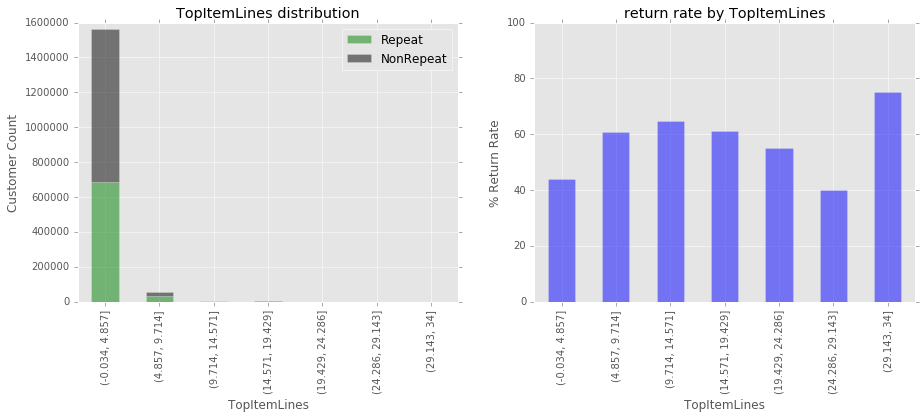

In [229]:
plot_rrate_hist(df, 'TopItemLines', 7)

### product variety VS return visits
- Very low variety (many of the same product) yield higher repeat business
- Most customers are buying one of each product in their basket

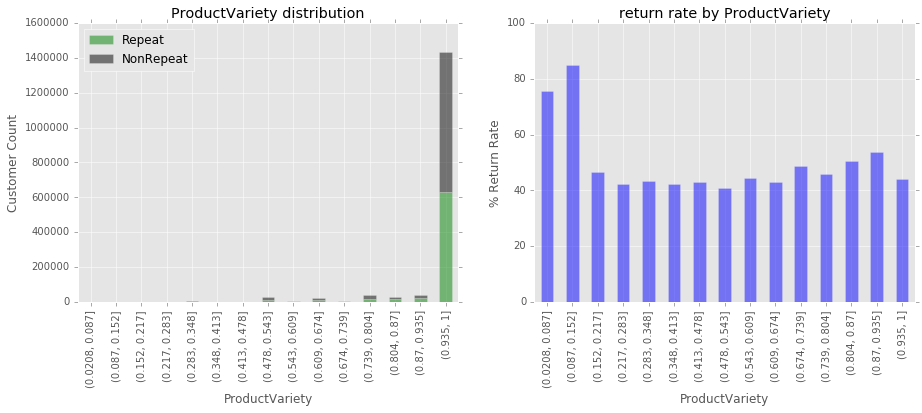

In [245]:
plot_rrate_hist(df, 'ProductVariety',15)

### day of week VS return visits
- Traffic seems equally distributed between days of the week
- More repeat customers shop on weekdays in number and on a percentage basis

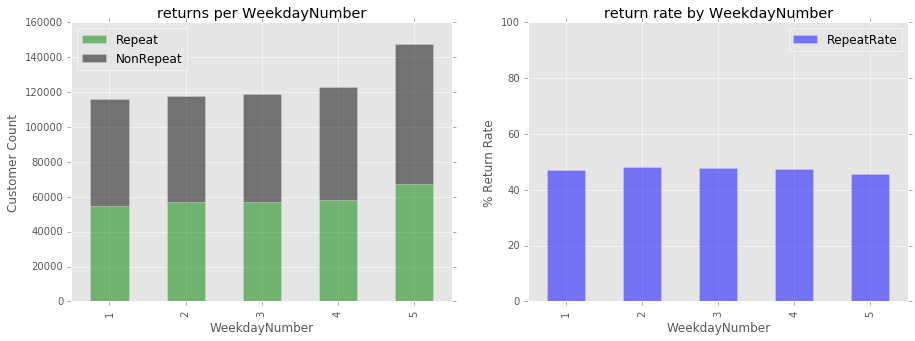

In [225]:
plot_rrate(df_biz, ['WeekdayNumber'])

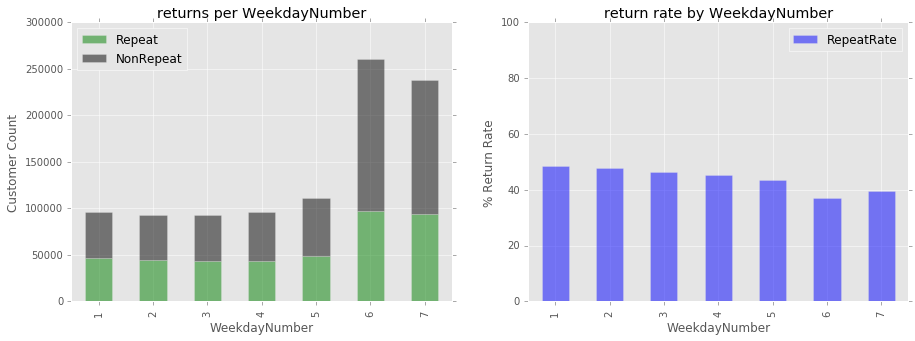

In [226]:
plot_rrate(df_nobiz, ['WeekdayNumber'])

### month VS repeat business
- Sales seem normally distributed across months
- Return rate is steady across months (slightly higher in January)

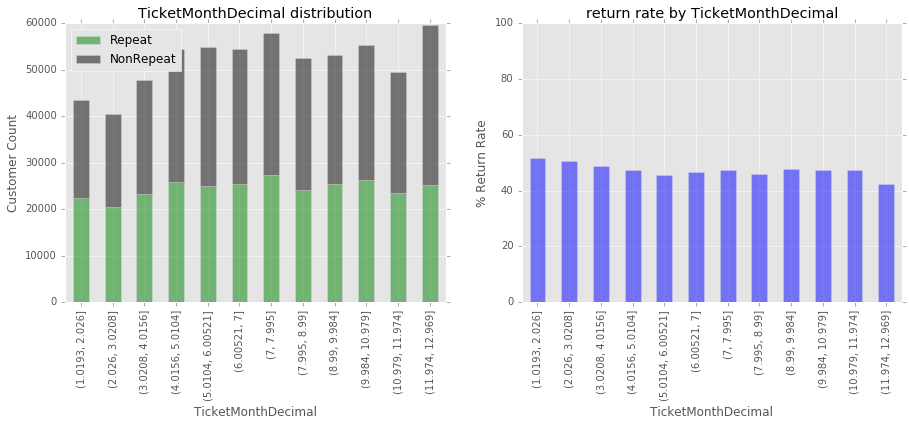

In [227]:
plot_rrate_hist(df_biz, 'TicketMonthDecimal', 12)

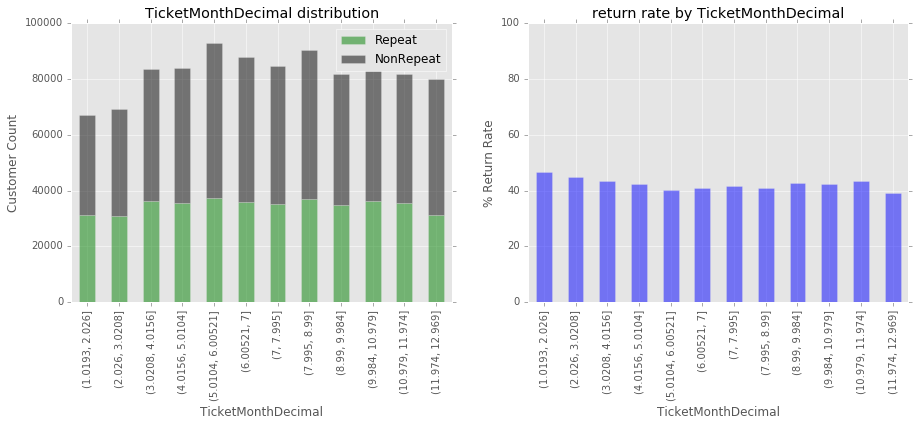

In [228]:
plot_rrate_hist(df_nobiz, 'TicketMonthDecimal', 12)

### time of day VS repeat business
- of course, sales are focussed around 12PM - 7PM, with outliers on either end
- repeat business is slightly more likely between 9AM-11AM and at 6PM

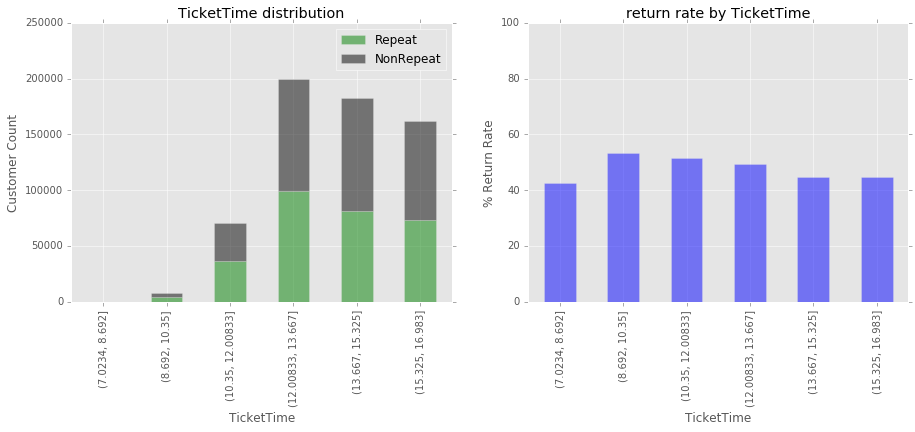

In [229]:
plot_rrate_hist(df_biz, 'TicketTime', 6)

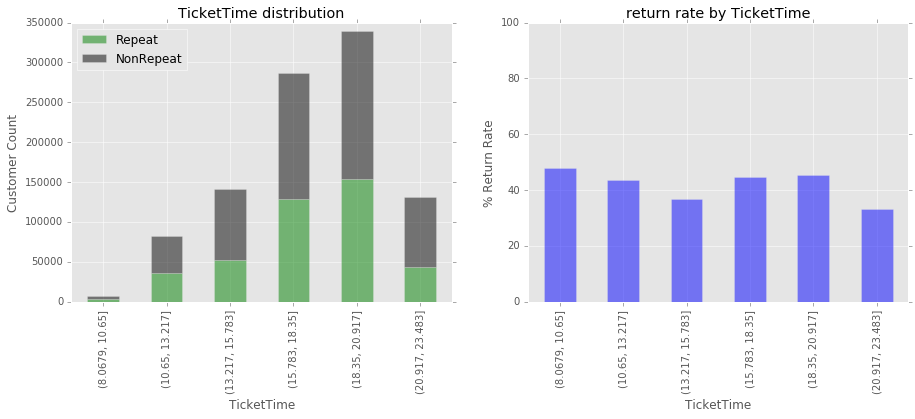

In [230]:
plot_rrate_hist(df_nobiz, 'TicketTime', 6)

### produce shopping VS repeat business
- Feature 'BoughtProduce' comes from domain knowledge about customer behavior
- Produce shopping must be done locally (natural filter for tourists)
- Fresh produce is uniquely "Italian"... maybe these shoppers use Eataly as a grocery store

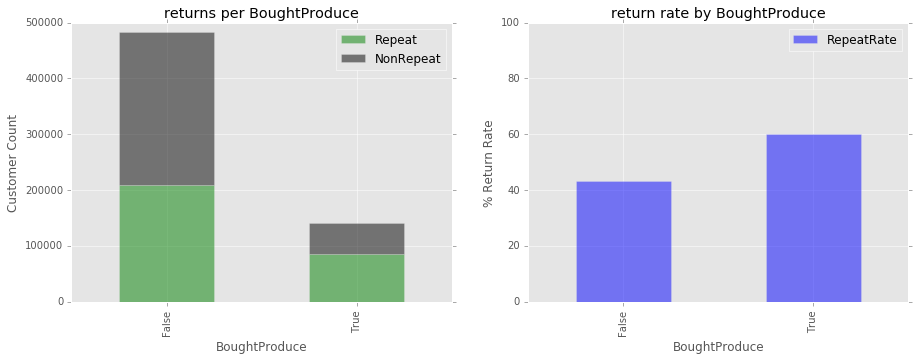

In [231]:
plot_rrate(df_biz, ['BoughtProduce'])

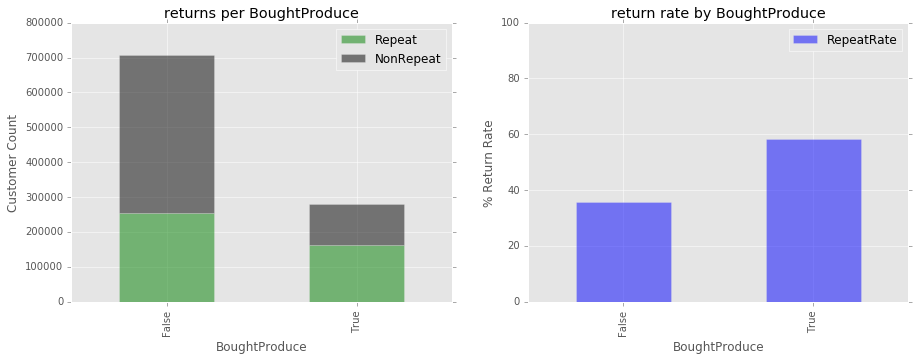

In [232]:
plot_rrate(df_nobiz, ['BoughtProduce'])

### returning bags VS repeat business
- Another feature from domain knowledge
- Eataly refunds customers $0.05 for returning shopping bags
- This would definintely suggest prior visits on by the customer
- Far more customers do no return bags (98%), so feature may not work

In [233]:
get_rrate(df, ['ReturnedBags'])

,Repeat,NonRepeat,CustCount,CustDist,RepeatRate,RepeatDist
ReturnedBags,,,,,,
False,701234,893643,1594877,98.937411,43.967905,98.563921
True,10217,6912,17129,1.062589,59.647382,1.436079


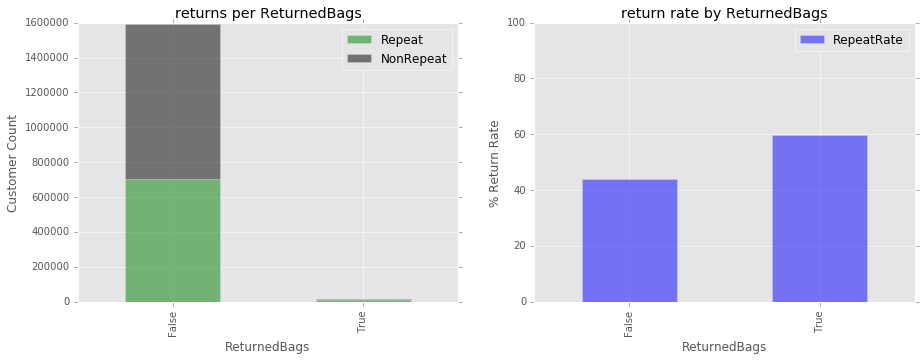

In [234]:
plot_rrate(df, ['ReturnedBags'])

### Net spend vs repeat business
- First pair of graphs show spending distributions from 25th - 75th percentiles
- Second pair of graphs show spending distributions from \$0 - $250
- Both pairs suggest natural tendancy towards smaller dollar value tickets, but constant probability of return

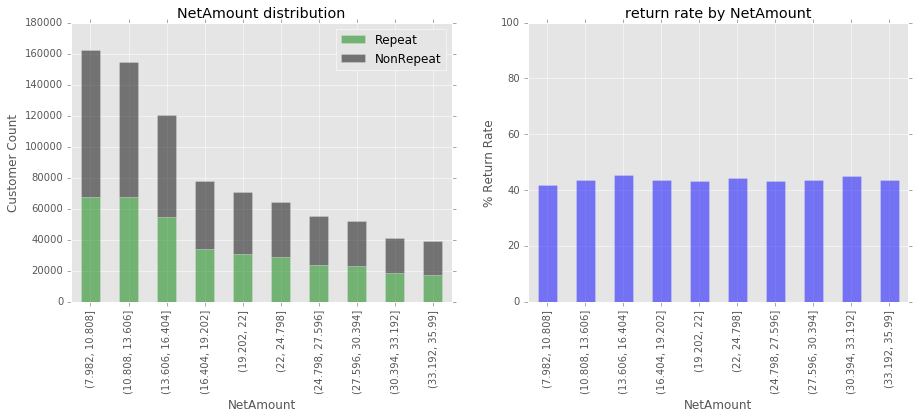

In [235]:
# frequency & probability for spenders between $0 and $250 (to account for outliers in sales)
plot_rrate_hist(df[(df['NetAmount']<36) & (df['NetAmount']>8)], 'NetAmount',10)

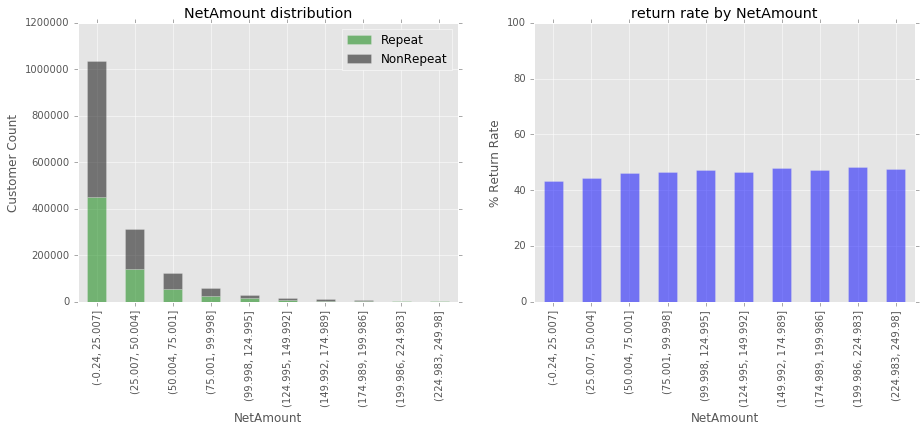

In [236]:
# frequency & probability for spenders between $0 and $250 (to account for outliers in sales)
plot_rrate_hist(df[(df['NetAmount']<250) & (df['NetAmount']>0)], 'NetAmount',10)

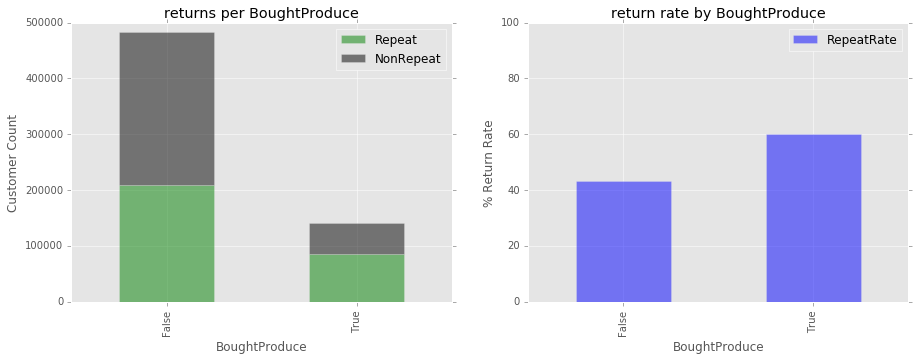

In [237]:
plot_rrate(df_biz, ['BoughtProduce'])

### export data as split flat files

In [247]:
# export data into smaller files for github
outfp = os.path.join('data','post_eda')
step = 25000

for r in range(int(ceil(len(df) / step))):
    r_low = r*step
    r_high = (r+1)*step
    f_name = 'data_'+str(r).zfill(3)+'.csv'

    filename = os.path.join(outfp, f_name)
    
    df.iloc[r_low:r_high].to_csv(filename, index=None)